# Identify which events caused more errors

This notebook answers the following questions:

- [X] What is the ratio of UI_EVENT_SOURCE field error types to active reports?
- [X] What types of PAGE_CONTEXT and PAGE_ENTITY_TYPE fields are present in active report data?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML

### Aligning data visualizations

The following code is used to center and align the visualizations laid out below.

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""") 

### Loadind Data

In [3]:
source_path_ar = "datasets/active_reports.csv"

active_reports = pd.read_csv(source_path_ar)

source_path_le = "data/Salesforce/ELF/LightningError/2022-06-06_LightningError.csv"

lightning_error = pd.read_csv(source_path_le)

### Description of the fields under analysis

Below is the definition of the fields being analyzed in this task.

1. **UI_EVENT_SOURCE**: The source of the error event;
2. **PAGE_CONTEXT**: Context of the page where the event occurred;
3. **PAGE_ENTITY_TYPE**: The entity type of the event.
3. **REPORT_ID_DERIVED**: The 18-character case insensitive ID of the report that was run.

The definitions of UI_EVENT_SOURCE, PAGE_CONTEXT, and PAGE_ENTITY_TYPE can be found in this [reference](https://developer.salesforce.com/docs/atlas.en-us.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_lightningerror.htm), and the definition of REPORT_ID_DERIVED can be found in this [reference](https://developer.salesforce.com/docs/atlas.en-us.238.0.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_report.htm).

## 1. What is the ratio of UI_EVENT_SOURCE field error types to active reports?

Next, we analyze the proportion of error types in relation to active reports.

- Utility function used to generate the REPORT_ID_DERIVED field in the LightningError table:

In [4]:
run_report_api_resource = "/lightning/r/"

def get_report_info_from_endpoint(page_url):
    page_url = str(page_url)
    if page_url.startswith(run_report_api_resource):
        uri = page_url.split(run_report_api_resource)
        if len(uri) >= 2:
            report_type, report_id_derived = uri[1].split("/")[:2]
            return report_type, report_id_derived

- Data processing:

In [5]:
lightning_error['REPORT_ID_DERIVED'] = lightning_error.PAGE_URL.apply(get_report_info_from_endpoint).str[1]
lightning_error = lightning_error.dropna(subset = ['REPORT_ID_DERIVED'],inplace = False)

merged_data = pd.merge(left = active_reports, right = lightning_error, on='REPORT_ID_DERIVED', how= 'inner')

merged_data = merged_data[['REPORT_ID_DERIVED', 'PAGE_CONTEXT', 'UI_EVENT_SOURCE', 'PAGE_ENTITY_TYPE']]

merged_data

,REPORT_ID_DERIVED,PAGE_CONTEXT,UI_EVENT_SOURCE,PAGE_ENTITY_TYPE
0,00O0b000004kTazEAE,reports:reportBase,Error,Report
1,00O0b000004kTazEAE,reports:reportBase,Error,Report
2,00O0b000004kTazEAE,reports:reportBase,Error,Report
3,00O0b000004kTazEAE,reports:reportBase,Error,Report
4,00O0b000004kTazEAE,reports:reportBase,Error,Report
...,...,...,...,...
53598,00O0b000004kkZKEAY,reports:reportBase,Error,Report
53599,00O0b000004kkZKEAY,reports:reportBase,Error,Report
53600,00O0b000004kkZKEAY,reports:reportBase,Error,Report
53601,00O0b000004kkZKEAY,reports:reportBase,Error,Report


As we can see in the pie chart below, the Error and TypeError types are the only error types present in the data being analyzed; And type Error is considerably larger than type TypeError.

In [6]:
count1 = merged_data.groupby("UI_EVENT_SOURCE").count()
count1 = count1[count1.columns[0]]

dict(count1)

print('Quantification of error types by active reporting:\n')
sum_count = 0
for k in dict(count1):
    k_str = k + ':'
    print(f"{k_str:<10} {dict(count1)[k]:>}")
    sum_count += dict(count1)[k]
    
print(f"{'Total:':<10} {sum_count:>}")

Quantification of error types by active reporting:

Error:     42064
TypeError: 11539
Total:     53603


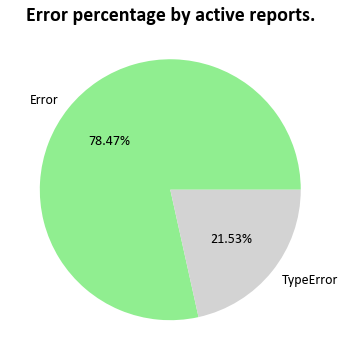

In [7]:
plt.figure(figsize=(6,6))

plt.title("Error percentage by active reports.", fontsize=20, fontweight="bold", fontname="Calibri");
plt.pie(count1.sort_values(ascending=False), autopct='%1.2f%%', labels = ['Error','TypeError'], 
        textprops = {'size': 14, 'font': 'Calibri'}, colors= ['lightgreen' ,'lightgrey'])

plt.show()

## 2. What types of PAGE_CONTEXT and PAGE_ENTITY_TYPE fields are present in active report data?

The tables below highlight that the only PAGE_CONTEXT type present in this sample is **reports:reportBase**, and the only PAGE_ENTITY_TYPE type is **Report**.

In [8]:
count2 = merged_data.groupby("PAGE_CONTEXT").count()
count2

,REPORT_ID_DERIVED,UI_EVENT_SOURCE,PAGE_ENTITY_TYPE
PAGE_CONTEXT,,,
reports:reportBase,53603,53603,53603


In [9]:
count3 = merged_data.groupby("PAGE_ENTITY_TYPE").count()
count3

,REPORT_ID_DERIVED,PAGE_CONTEXT,UI_EVENT_SOURCE
PAGE_ENTITY_TYPE,,,
Report,53603,53603,53603
